### Creating Feature Vectors - Between tuples

In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
import word_definite as WD
from MatDB import *
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

In [12]:
import numpy as np
import math
np.set_printoptions(suppress=False, precision=16)

In [4]:
matDB = MatDB()

In [5]:
WD.word_definite_extInit(matDB)
# node2 = WD.word_definite('tIkzRam', 'tIkzRa', 31, 0, 0)
node1 = WD.word_definite('Adi', 'Adi', 31, 0, 0)
node2 = WD.word_definite('ca', 'ca', 2, 0, 1)
# node1 = WD.word_definite('koRam', 'koRa', 31, 0, 1)
print(node1)
print(node2)

feats = WD.Get_Features(node1, node2)
print(feats.shape)

443
WD_Node[C: 0, P: 0, Adi @(31) => Adi]
WD_Node[C: 1, P: 0, ca @(2) => ca]
(788992, 1)


In [6]:
matDB.mat_lem2lem_countonly['koRa']['Adi']

10

In [7]:
matDB.mat_lemCount_1D['Adi']

195905

In [10]:
feats.nbytes/(1024*1024)

6.01953125

In [7]:
# for i in range(1335):
#     if feats[i] > 0:
#         print(i) 
# feats[-500:]

### Get PMI B/W Tuples

In [ ]:
# pmi(x;y) = -log2[p(x|y)/p(x)]
# def PMI(x, y, _pbModel):
#     # x : node1
#     # y : node2
#     if(x in _pbModel.fullCo_oc_mat[y]):
#         p_x_given_y = _pbModel.fullCo_oc_mat[y][x]/_pbModel.unigram_counts[y]
#         p_x = _pbModel.unigram_counts[x]/_pbModel.unigram_total_count
#         #print(p_x_given_y, ' ', p_x)
#         return -math.log2(p_x_given_y/p_x)
#     else:
#         p_x_given_y = 1/_pbModel.unigram_counts[y]
#         p_x = _pbModel.unigram_counts[x]/_pbModel.unigram_total_count
#         #print(p_x_given_y, ' ', p_x)
#         return -math.log2(p_x_given_y/p_x)

### Get tuple pairs for feature importance 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import word_definite as WD
from MatDB import *
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

In [3]:
import numpy as np
import math
np.set_printoptions(suppress=False, precision=16)

In [4]:
matDB = MatDB()

In [5]:
WD.word_definite_extInit(matDB)

443


In [6]:
len(matDB.mat_tupCount_1D)

217326

In [7]:
smallTupList = []
for tup1, val in matDB.mat_tupCount_1D.items():
    if val > 20:
        smallTupList.append(tup1)      

In [8]:
l = len(smallTupList)
print(l)

125596


In [9]:
batchCount = 10
perm = np.random.permutation(l)[:batchCount]
# perm2 = np.random.permutation(l)[:batchCount]

In [10]:
fN = 4*443**2 + 9*443 + 9
print(fN)

all_pairs = {}

index = 0
for k in range(batchCount):  
    tup1 = smallTupList[perm[k]]
    lem1 = tup1.split('_')
    cng1 = lem1[1]
    lem1 = lem1[0]
    
    node1 = WD.word_definite(None, lem1, cng1, 0, 0)
    for tup2, co_occurrence in matDB.mat_tup2tup_countonly[tup1].items():
        if co_occurrence > 4:
            lem2 = tup2.split('_')
            cng2 = lem2[1]
            lem2 = lem2[0]
            node2 = WD.word_definite(None, lem2, cng2, 0, 1)
            all_pairs[index] = (node1, node2)
            index += 1
            
print('Will get feature vectors for {} pairs'.format(index))
total_examples = index


788992
Will get feature vectors for 18 pairs


In [11]:
pairs_per_file = 10
for pairx in range(math.ceil(len(all_pairs)/pairs_per_file)):
    subset_pairs = range(pairx*pairs_per_file, min(len(all_pairs), (pairx + 1)*pairs_per_file))
    featureMatrix = np.zeros((fN, len(subset_pairs)))
    targetDict = {}
    index = 0
    current_pairs = {}
    for hi in subset_pairs:
        node1 = all_pairs[hi][0]
        node2 = all_pairs[hi][1]
        current_pairs[index] = '{}^{}'.format(node1.tup, node2.tup)
        featureMatrix[:, index, None] = WD.Get_Features(node1, node2)
        targetDict[index] = (matDB.mat_tup2tup_countonly[node1.tup][node2.tup],\
                              matDB.mat_lem2lem_countonly[node1.lemma][node2.lemma],\
                              matDB.mat_lem2tup_countonly[node1.lemma][node2.tup],\
                              matDB.mat_tup2lem_countonly[node1.tup][node2.lemma])
        index += 1
        if index % min(math.ceil(pairs_per_file/2), 100) == 0:
            print('Checkpoint S{}E{} of {}'.format(pairx, index, pairs_per_file))
    pickle.dump({'all_pairs': current_pairs, 'featureMatrix': featureMatrix, 'targetDict': targetDict},\
        open('outputs/featureSet_{}samples_8L_{}.p'.format(pairs_per_file, pairx), 'wb'), protocol = 4)

Checkpoint S0E5
Checkpoint S0E10
Checkpoint S1E5


In [14]:
featureBox = pickle.load(open('outputs/featureSet_10samples_8L_1.p', 'rb'))
print('All Pairs:')
display(featureBox['all_pairs'])
print('Feature Matrix:')
display(featureBox['featureMatrix'])
print('Target Dict(counts of word2word, lem2lem, lem2word, word2lem):')
display(featureBox['targetDict'])

All Pairs:


{0: 'vyaYjaka_3^sadBAva_169',
 1: 'vyaYjaka_3^evam_2',
 2: 'vyaYjaka_3^Adi_3',
 3: 'kalpa_99^vajra_3',
 4: 'kalpa_99^ca_2',
 5: 'kalpa_99^agni_3',
 6: 'kalpa_99^deva_3',
 7: 'kalpa_99^Sara_99'}

Feature Matrix:


array([[ 0.0051107325383305,  0.0051107325383305,  0.0119250425894378, ...,
         0.0023538026990271,  0.0017261219792865,  0.0006799874463856],
       [ 0.010221465076661 ,  0.0357751277683135,  0.0374787052810903, ...,
         0.039334658437075 ,  0.039334658437075 ,  0.0040799246783136],
       [ 0.0051107325383305,  0.0051107325383305,  0.0085178875638842, ...,
         0.0020922690658019,  0.0012030547128361,  0.0003138403598703],
       ..., 
       [ 0.                ,  0.                ,  0.                , ...,
         0.                ,  0.                ,  0.                ],
       [ 0.                ,  0.                ,  0.                , ...,
         0.                ,  0.                ,  0.                ],
       [ 0.                ,  0.                ,  0.                , ...,
         0.                ,  0.                ,  0.                ]])

Target Dict(counts of word2word, lem2lem, lem2word, word2lem):


{0: (6, 3, 3, 3),
 1: (5, 3, 3, 3),
 2: (5, 7, 5, 5),
 3: (6, 19, 19, 5),
 4: (18, 223, 222, 14),
 5: (14, 45, 40, 14),
 6: (6, 33, 23, 6),
 7: (6, 13, 6, 7)}

In [49]:
featureMatrix.shape

(788992, 2)

In [16]:
for key, val in all_pairs.items():
    all_pairs[key] = (val[0].tup, val[1].tup)

In [19]:
featureMatrix.nbytes/(1024*1024)

8595.890625

In [18]:
featureMatrix.shape

(788992, 1428)

In [21]:

pickle.dump({'all_pairs': all_pairs, 'featureMatrix': featureMatrix[:, 400:800], 'targetMatrix': targetMatrix},\
            open('outputs/featureSet_1428p_8L_1.p', 'wb'), protocol = 4)
pickle.dump({'all_pairs': all_pairs, 'featureMatrix': featureMatrix[:, 800:], 'targetMatrix': targetMatrix},\
            open('outputs/featureSet_1428p_8L_2.p', 'wb'), protocol = 4)

In [47]:
varVec = np.zeros((fN, 1))
meanVec = np.zeros((fN, 1))

In [48]:
for fk in range(fN):
    varVec[fk] = np.var(featureMatrix[fk, :])
    meanVec[fk] = np.mean(featureMatrix[fk, :])

In [68]:
fanoFactors = varVec/meanVec

d:\program files\anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [71]:
fanoFactors = fanoFactors[~np.isnan(fanoFactors)]
fanoFactors = fanoFactors[fanoFactors > 0.0025]

(array([ 10.,   1.,   1.,   2.,   0.,   3.,   2.,   1.,   0.,   1.]),
 array([ 0.0027130129321566,  0.0049483498450054,  0.0071836867578543,
         0.0094190236707031,  0.0116543605835519,  0.0138896974964008,
         0.0161250344092496,  0.0183603713220984,  0.0205957082349473,
         0.0228310451477961,  0.0250663820606449]),
 <a list of 10 Patch objects>)

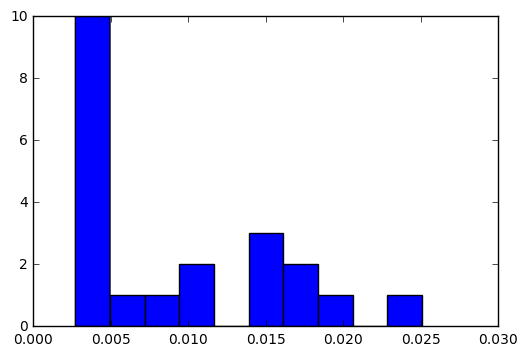

In [72]:
plt.hist(fanoFactors)